# Investigate a Sample

### First run this cell

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *
import json

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor() as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    d = batch_resize(d, bs)
    print('resized')
    d_maxes = np.max(d,(1,2))[:,None,None]
    d /= d_maxes
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size) :
        self.images = images
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_img
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img

def remove_background(sample, thresh = 500, old_tag=None, new_tag=None,blanker = 30):
    d = sample.raw_data.data.copy()
    d_shape = d.shape
    n_shape, p_shape = d_shape[0:2], d_shape[2:]
    d[:,:,p_shape[0]//2 - blanker:p_shape[0]//2 + blanker, p_shape[0]//2 - blanker: p_shape[0]//2 + blanker] = np.zeros((2*blanker,2*blanker))
    maskx, masky = np.where(d.sum(axis=(2,3))<thresh)
    if old_tag !=None:
        clustmap = sample.all_maps[old_tag].copy()
        clustmap += 1
        clustmap[maskx, masky] = 0 
        newmap = np.zeros_like(clustmap)
        for i, o in enumerate(np.unique(clustmap)):
            newmap[np.where(clustmap == o)] = i
        newmap += 1
        if new_tag != None:
            sample.all_maps[new_tag] = newmap
        return newmap
    else:
        return np.where(d.sum(axis=(2,3))<thresh, 0, 1)

def show_cluster_patterns(sample, tag):
    uis = np.unique(sample.all_maps[tag])
    od = np.zeros((uis.size, 512, 256))
    for x,i in enumerate(uis):
        p = resize(sample.all_patterns[tag][i-1], (256,256))
        n = resize(np.where(sample.all_maps[tag] == i, p.max(), 1), (256,256))
        p[0,:] = p.max()
        o = np.concatenate([n,p], axis = 0)
        od[x] = o
    return hs.signals.Signal2D(od)

def signal_boosted_scan(sample, tag):
    uts = np.unique(sample.all_maps[tag])
    blank = np.zeros_like((sample.raw_data))
    for t in uts:
        blank[np.where(sample.all_maps[tag]==t)] = sample.all_patterns[tag][t-1]
    return hs.signals.Signal2D(blank)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2021-11-15 12:44:58.843601: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Check the GPU can be found

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2021-11-15 12:45:13.187693: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-15 12:45:13.188822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-15 12:45:13.188848: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-15 12:45:13.192114: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-15 12:45:13.194876: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-11-15 12:45:13.196026: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

In [3]:
fdp = Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/')

dl = fdp.ls()
[i for i in enumerate(dl)]

[(0,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_152115')),
 (1,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_150802')),
 (2,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_135457')),
 (3,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_141948')),
 (4,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_151250')),
 (5,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_150242')),
 (6,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_110741')),
 (7,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_141615')),
 (8,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_123525')),
 (9,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_115723')),
 (10,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_142234')),
 (11,
  Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_1

### Select your data set

In [4]:
#Can just set a Path to your dataset
dp = Path('something/something/file.hdf5')

In [112]:
#Or can use the index from the list above

#Can set index directly 
select = 3

#or find the timestamp
#ts = '123525'
#select = np.argmax([str(x).find(ts) for x in dl])

In [101]:
dp = dl[select].walk('.hdf5', 'Model')[0]
dp

Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_135457/20210925_135457_data.hdf5')

### Set the Model Path

In [113]:
mp = dp.redirect('Final_Models')
mp

Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_135457/Final_Models')

### Create a ProcessedSample Object

In [114]:
sample = ProcessedSample(dp, 'Test')

### Match the rebinning from the training

In [115]:
rebin_factor = 3

In [116]:
sample.rebin(rebin_factor)

<IPython.core.display.Javascript object>


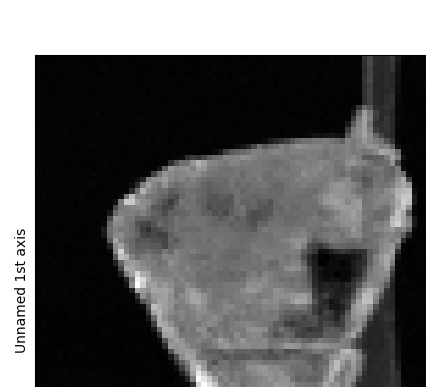

<IPython.core.display.Javascript object>


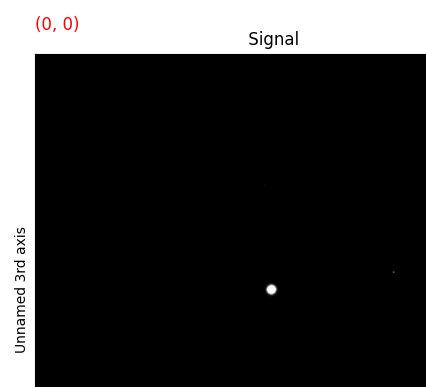

In [117]:
sample.raw_data.plot()

### Pre-process the data to speed up later functions (can avoid this if there are memory constraints)

In [118]:
sample.save_ml_manipulation('full_ds', data_manip)

started data manipulations
57
resized


### Set the hparams, can pull these out of the info dictionary

In [119]:
info_path = dp.redirect('Final_Models',1).walk('.json')[0]

In [120]:
with open(info_path, 'r') as f:
    info = json.load(f)

In [121]:
hparams= info['rerun_full_3bin']['hparams']

In [122]:
sample.set_model_data('/dls/e02/data/2021/mg28034-1/processing/Models/New','cnn',hparams['LAT'],use_generic_model = True)

### Check the model has built

In [123]:
model = create_vae_model(hparams)
model.summary()

Model: "vae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_13 (Functional)   [(None, 2), (None, 2), (N 3654660   
_________________________________________________________________
functional_15 (Functional)   (None, 128, 128, 1)       3394817   
Total params: 7,049,477
Trainable params: 7,049,477
Non-trainable params: 0
_________________________________________________________________


### Load in the trained weights

In [124]:
best_model = mp.walk('.hdf5')[0]
best_model

Path('/dls/e02/data/2021/mg28749-1/processing/Calibrated/20210925_135457/Final_Models/rerun_full_3bin_best_model.hdf5')

In [125]:
model.load_weights(best_model)

### You now need to set the model to the sample 

In [126]:
sample.set_model(model)

### You can encode the data you pre-processed earlier (or will default to sample.raw_data)

In [127]:
sample.encode('vae',input_data_tag='full_ds')

### You can inspect the reconstructed image and compare it to the raw data

<IPython.core.display.Javascript object>


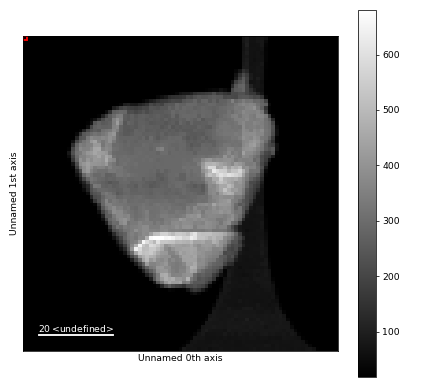

<IPython.core.display.Javascript object>


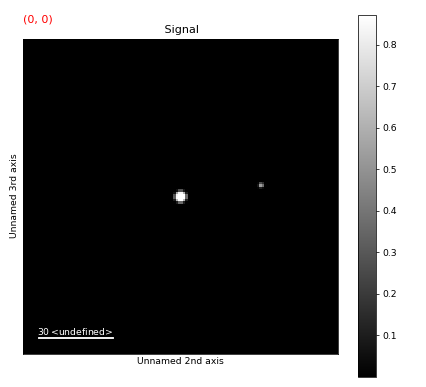

In [128]:
sample.inspect_model()

<IPython.core.display.Javascript object>


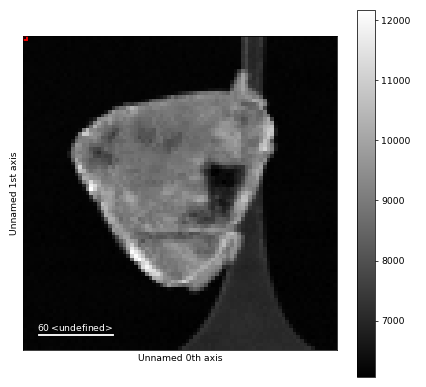

<IPython.core.display.Javascript object>


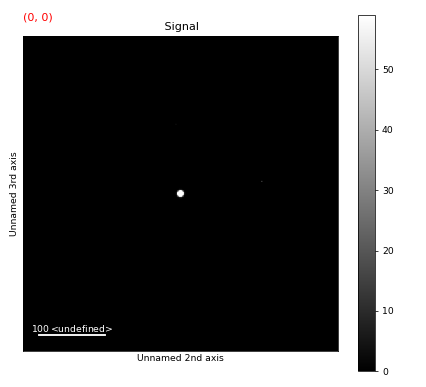

In [129]:
sample.raw_data.plot()

### You can the use the auto_cartography to map the latent terrain and cluster your encoded data

In [130]:
tmp_dir = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/tmp')

(112, 160, 128, 128)


<IPython.core.display.Javascript object>


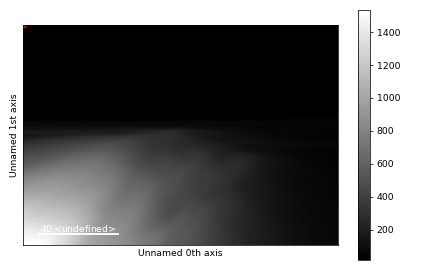

<IPython.core.display.Javascript object>


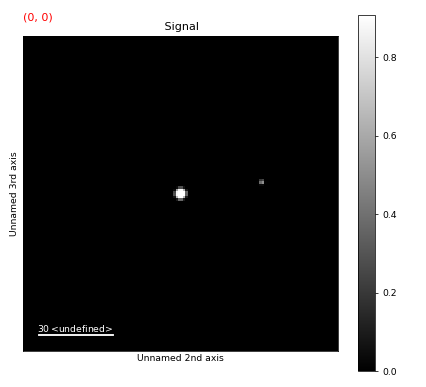

[########################################] | 100% Completed |  1.2s
<ElectronDiffraction2D, title: , dimensions: (156, 108|128, 128)>
Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=16
  centre=None
scikit-learn estimator:
NMF(n_components=16)
no mask
got data
normalised
0
(1, 112, 160)
1
(1, 112, 160)
2
(1, 112, 160)
3
(1, 112, 160)
4
(1, 112, 160)
5
(1, 112, 160)
6
(1, 112, 160)
7
(1, 112, 160)
8
(1, 112, 160)
9
(1, 112, 160)
10
(1, 112, 160)
11
(1, 112, 160)
12
(1, 112, 160)
13
(1, 112, 160)
14
(1, 112, 160)
15
(1, 112, 160)
concat
norm start
norm finished
(896, 640)


<IPython.core.display.Javascript object>


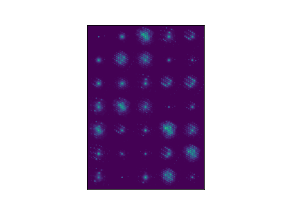

<IPython.core.display.Javascript object>


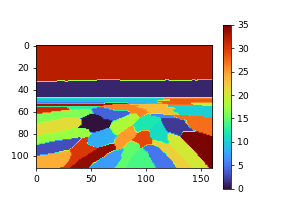

In [131]:
sample.auto_cartography(tmp_dir, terr_resolution=16, n_comps=16, n_segments=36, tag= 'vae',pca_skips=1, use_terr_decomp=False, norm = True, mask_PCA=False, inc_nav=True)

### View the result of the clustering

<IPython.core.display.Javascript object>


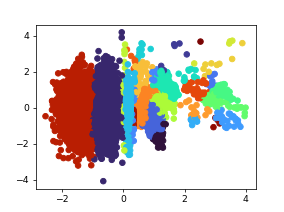

In [132]:
X, Y = sample.encoded_data[:,0], sample.encoded_data[:,1] 
plt.figure()
plt.scatter(X, Y, c = sample.all_maps['vae'], cmap = 'turbo')

<IPython.core.display.Javascript object>


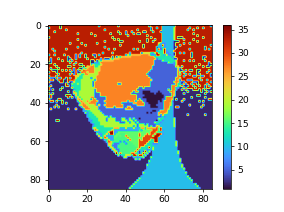

In [133]:
sample.imshow(None, 'vae')

### Remove the pixels corresponding to the background or support

In [134]:
remove_background(sample, old_tag = 'vae', new_tag = 'vl_vae')

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

<IPython.core.display.Javascript object>


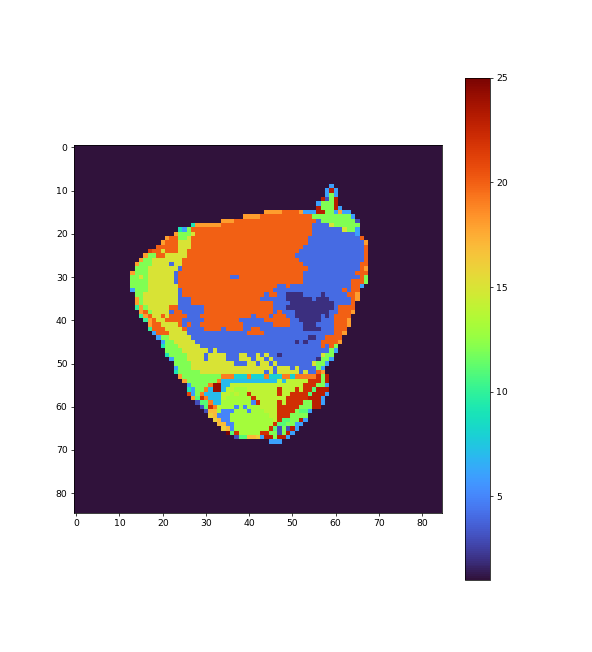

In [135]:
sample.imshow(None, 'vl_vae')

### Calculate the patterns associated with each cluster

(2380, 2380)


<IPython.core.display.Javascript object>


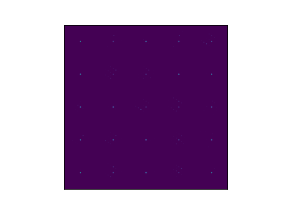

In [136]:
sample.get_map_patterns('vl_vae', method = 'mean', recompute=True)

### View the patterns and their associated regions

<IPython.core.display.Javascript object>


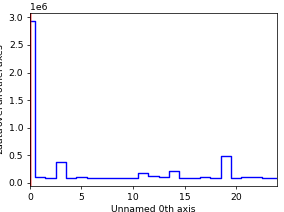

<IPython.core.display.Javascript object>


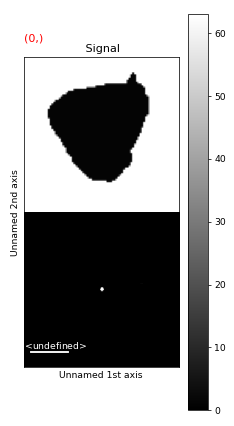

In [137]:
show_cluster_patterns(sample, 'vl_vae').plot()

### View a signal boosted representation of the sample

<IPython.core.display.Javascript object>


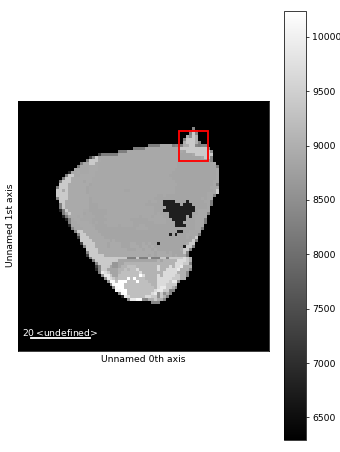

<IPython.core.display.Javascript object>


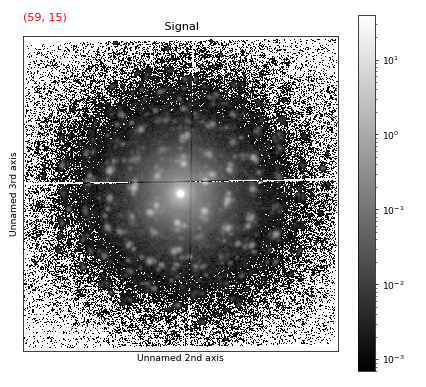

In [138]:
signal_boosted_scan(sample, 'vl_vae').plot()